In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cwd = os.getcwd()
os.chdir('results')

from matplotlib.lines import Line2D

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7
}

plt.rcParams.update(tex_fonts)

In [3]:
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
styles = ['-', '--', '-.', ':']
line_cs = [(c, s) for s in styles for c in colours]

## Comparison plot

In [4]:
datasets = ['LinearGaussian', 'EconDensity', 'ArmaJump', 'SkewNormal', 'GaussianMixture', 'LGGMD']

models = ['NCP', 'NFlow', 'KMN', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation', 'NNKCDE', 'RFCDE', 'FlexCodeModel', 'LinCDE']

metric = 'kolmogorov_smirnov'

all_results = {}
for model in models:
    grouped_results = {}
    for dataset in datasets:
        results_df = pd.read_pickle(f'{dataset}_{model}_results.pkl')
        #take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
        if model in ['NCP']:
            tmp_grouping = pd.DataFrame(results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.mean(np.row_stack(x))))
            tmp_grouping.rename(columns={metric: 'mean_'+metric}, inplace=True)
            tmp_grouping['mean_std_'+metric] = results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.mean(np.row_stack(x), axis=1)).apply(np.std)
        else:
            tmp_grouping = pd.DataFrame(results_df.groupby(['n_samples'])[metric].apply(lambda x: np.mean(np.row_stack(x))))
            tmp_grouping.rename(columns={metric: 'mean_'+metric}, inplace=True)
            tmp_grouping['mean_std_'+metric] = results_df.groupby(['n_samples'])[metric].apply(lambda x: np.mean(np.row_stack(x), axis=1)).apply(np.std)

        grouped_results[dataset] = tmp_grouping.reset_index()

    all_results[model] = grouped_results

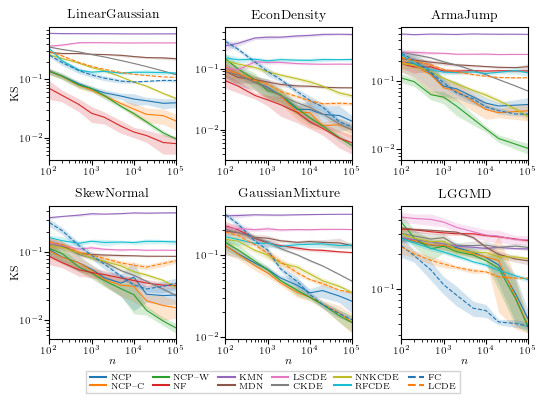

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(5.5, 3.8))
axs = axs.flatten()

labels = []
for i, dataset in enumerate(datasets):
    ax = axs[i]
    count = 0
    for model in models:
        results = all_results[model][dataset]
        if model in ['NCP']:
            for postprocess in ['None', 'centering', 'whitening']:
                n_samples = results[results['postprocess'] == postprocess]['n_samples']
                mean_score = results[results['postprocess'] == postprocess]['mean_'+metric]
                std_score = results[results['postprocess'] == postprocess]['mean_std_'+metric]
                label = ''.join(c for c in model if c.isupper()) +' - ' + postprocess.capitalize()[0]
                labels.append(label)
                ax.plot(n_samples, mean_score, label= label, color = line_cs[count][0], linestyle = line_cs[count][1], linewidth=0.8)
                ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, color = line_cs[count][0], alpha=0.2, linewidth=0)
                count += 1
        else:
            n_samples = results['n_samples']
            mean_score = results['mean_'+metric]
            std_score = results['mean_std_'+metric]
            label = ''.join(c for c in model if c.isupper())
            labels.append(label)
            ax.plot(n_samples, mean_score, label=label, color = line_cs[count][0], linestyle = line_cs[count][1], linewidth=0.8)
            ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2, color = line_cs[count][0], linewidth=0)
            count += 1

    ax.set_title(f'{dataset}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xmargin(0)
    ax.tick_params(axis="x", pad=2)
    ax.tick_params(axis="y", pad=1)

axs[3].set_xlabel('$n$', labelpad=0)
axs[4].set_xlabel('$n$', labelpad=0)
axs[5].set_xlabel('$n$', labelpad=0)
axs[0].set_ylabel('KS', labelpad=0)
axs[3].set_ylabel('KS', labelpad=0)

custom_lines = [Line2D([0], [0], color = line_cs[i][0], linestyle = line_cs[i][1]) for i in range(len(models)+2)]
labels = [r'NCP', 'NCP--C', 'NCP--W', 'NF', 'KMN', 'MDN', 'LSCDE', 'CKDE', 'NNKCDE', 'RFCDE', 'FC', 'LCDE']
fig.legend(custom_lines, labels, loc = 'lower center', ncol=6, fancybox=False, borderaxespad=-.5, labelspacing=0.1, edgecolor='lightgray',
           handletextpad=0.5, columnspacing=1, framealpha=1, bbox_transform=fig.transFigure, bbox_to_anchor=(.5, -0.03), fontsize=6)
plt.tight_layout()
plt.show()

# fig.savefig(cwd+f'/figures/{metric}_distance.pdf', bbox_inches='tight')